# Creating the data

Using the Chambole implementation of Total Variation denoising to denoise images. 

In [11]:
from skimage import io, img_as_float
from skimage.restoration import denoise_tv_chambolle
from matplotlib import pyplot as plt
from pathlib import Path
import pathlib
import os


In [45]:
test_dir = Path('G:/My Drive/Lab/Grain-U-Net/data/test_Pt/')
out_dir = Path('G:/My Drive/Lab/Grain-U-Net/data/test_Pt_denoised/20um')

images = []

for FOV in test_dir.glob('*'):
    if not (FOV / 'raw').is_dir():
        continue
    for fname in FOV.glob('raw/*.png'):
        print(fname)
        img = img_as_float(io.imread(fname))
        images.append(img)

G:\My Drive\Lab\Grain-U-Net\data\test_Pt\20um\raw\Pt_94kx_Conical 5sec_1fs_20umObj_5frames_02_1.ser_99.png
G:\My Drive\Lab\Grain-U-Net\data\test_Pt\20um\raw\Pt_94kx_Conical 5sec_1fs_20umObj_5frames_02_1.ser_96.png
G:\My Drive\Lab\Grain-U-Net\data\test_Pt\20um\raw\Pt_94kx_Conical 5sec_1fs_20umObj_5frames_02_1.ser_98.png
G:\My Drive\Lab\Grain-U-Net\data\test_Pt\20um\raw\Pt_94kx_Conical 5sec_1fs_20umObj_5frames_02_1.ser_100.png
G:\My Drive\Lab\Grain-U-Net\data\test_Pt\20um\raw\Pt_94kx_Conical 5sec_1fs_20umObj_5frames_02_1.ser_97.png


In [47]:
weights = [10]
for weight in weights:
    os.makedirs(out_dir / str(weight), exist_ok=True)
    for j in range(len(images)):
        img = 255*images[j]
        DNimg = denoise_tv_chambolle(img, weight=weight, eps=0.0002, n_iter_max = 200)  #vary weight, 0.1 for now
        io.imsave(out_dir / str(weight) / 'weight={}_pre{}.png'.format(weight, j), img.astype('uint8'))
        io.imsave(out_dir / str(weight) / 'weight={}_post{}.png'.format(weight, j), DNimg.astype('uint8'))
    print('Finished weight ' + str(weight)  + '!')


Finished weight 10!


In [40]:
#MODIFIED

test_dir = Path('G:/My Drive/Lab/Grain-U-Net/data/train_atarashii_256/')
out_dir = Path('G:/My Drive/Lab/Grain-U-Net/data/train_atarashii_256_denoised/')

for FOV in test_dir.glob('*'):
    if not (FOV / 'image').is_dir():
        continue
    dn_dir = out_dir / pathlib.PurePath(FOV).name
    print(dn_dir)
    os.makedirs(dn_dir)
    os.makedirs(dn_dir / 'image')
    for fname in FOV.glob('image/*.png'):
        img = 255*img_as_float(io.imread(fname))
        DNimg = denoise_tv_chambolle(img, weight=5, eps=0.0002, n_iter_max = 200)
        save_dir = dn_dir / 'image' / pathlib.PurePath(fname).name
        print(str(save_dir))
        io.imsave(save_dir, DNimg.astype('uint8'))
        print('saving to ' + str(save_dir))
        break
    break

G:\My Drive\Lab\Grain-U-Net\data\train_atarashii_256_denoised\train_nouveaux_256
G:\My Drive\Lab\Grain-U-Net\data\train_atarashii_256_denoised\train_nouveaux_256\image\93.png
saving to G:\My Drive\Lab\Grain-U-Net\data\train_atarashii_256_denoised\train_nouveaux_256\image\93.png


# Testing dirty/* 

All this is just nabbed from the main notebook. change the model loaded and the test dir as needed, then run IOU test



5 images found
5/5 [==============================] - 40s 8s/step
made dir

Saving to G:\My Drive\Lab\Grain-U-Net\data\test_Pt_denoised\20um\predict_10\weight=10_post0.png
Min: 216.2654571533203, Max: 247.72998046875, Shape: (1200, 1200)


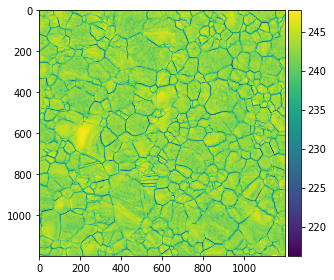


Saving to G:\My Drive\Lab\Grain-U-Net\data\test_Pt_denoised\20um\predict_10\weight=10_post1.png
Min: 217.15426635742188, Max: 247.75282287597656, Shape: (1200, 1200)

Saving to G:\My Drive\Lab\Grain-U-Net\data\test_Pt_denoised\20um\predict_10\weight=10_post2.png
Min: 218.1915283203125, Max: 247.62869262695312, Shape: (1200, 1200)

Saving to G:\My Drive\Lab\Grain-U-Net\data\test_Pt_denoised\20um\predict_10\weight=10_post3.png
Min: 218.11134338378906, Max: 248.0070037841797, Shape: (1200, 1200)

Saving to G:\My Drive\Lab\Grain-U-Net\data\test_Pt_denoised\20um\predict_10\weight=10_post4.png
Min: 219.88040161132812, Max: 248.18902587890625, Shape: (1200, 1200)


In [81]:
import os
from pathlib import Path
from skimage import io
from src import get_unet, image_generator
import numpy as np

target_size = (1200,1200)   
#test_dir = Path('data/test_Pt/')
test_dir = Path('G:/My Drive/Lab/Grain-U-Net/data/test_Pt_denoised/')

paths = list(test_dir.glob('*/10/*.png'))                           ### change here
print(f'{len(paths)} images found')
img_gen = image_generator(paths, target_size=target_size)

model = get_unet(input_size=(target_size + (1,)))
model.load_weights("G:/My Drive/Lab/Grain-U-Net/unet_grain_atrashii_posttune.hdf5")
results = 255 * model.predict(img_gen, steps=len(paths), verbose=1)

assert len(paths) == len(results), 'Not all the files ran'

for ind, path in enumerate(paths): 
    save_dir = path.parents[1] / 'predict_10'                        ###change here
    if not save_dir.is_dir():
        print('made dir')
        save_dir.mkdir()
        
    save_path = save_dir / path.with_suffix('.png').name
    result = results[ind, :, :, 0]
    
    print(f"\nSaving to {save_path}")
    print(f"Min: {np.min(result)}, Max: {np.max(result)}, Shape: {result.shape}")
    io.imsave(save_path, result.astype('uint8'))
    if ind == 0:
        io.imshow(result)
        io.show()

data\test_Pt_denoised\20um\predict_10\weight=10_post0.png
data\test_Pt_denoised\20um\predict_10\weight=10_post1.png
data\test_Pt_denoised\20um\predict_10\weight=10_post2.png
data\test_Pt_denoised\20um\predict_10\weight=10_post3.png
data\test_Pt_denoised\20um\predict_10\weight=10_post4.png


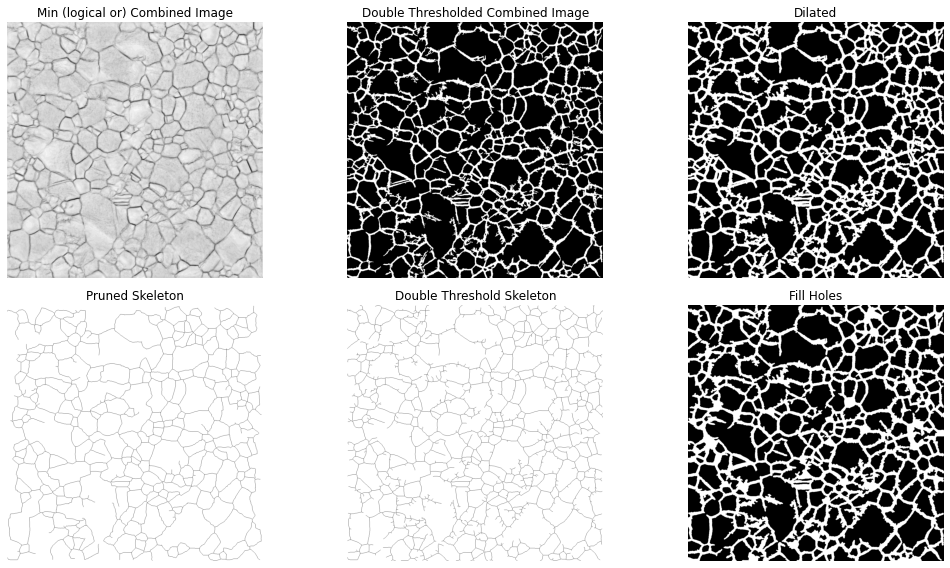

Saving to: data\test_Pt_denoised\20um\unet_skel.png


In [82]:
from pathlib import Path
from skimage import io
from src import post_process
import numpy as np

test_dir = Path('data/test_Pt_denoised/')
if 'test_dir' not in locals():
    test_dir = Path('data/test_Pt_denoised/')

process_args = {
        'compilation': 'min',
        'liberal_thresh': 240,
        'conservative_thresh': 220,
        'invert_double_thresh': True,
        'n_dilations': 2,
        'min_grain_area': 300,
        'prune_size': 100,
        'out_dict': True
}
    
for FOV in test_dir.glob('*'):
    if not (FOV / 'predict_10').is_dir():                              ### change
        continue
    
    imgs = np.array([])
    for fname in FOV.glob("predict_10/*.png"):                          ### change
        print(fname)
        if not fname.is_file(): continue
        
        img = io.imread(fname)
        if len(img.shape) > 2:
            img = img[:,:,0]
            
        if len(imgs) == 0:
            imgs = img
        else:
            imgs = np.dstack((imgs,img))
               
    data = post_process(imgs, **process_args)
    
    from matplotlib import pyplot as plt
    from src.visual_tools import *
    fig, axes = plt.subplots(2, 3, figsize=(15,8))

    for ax in axes.flatten():
        ax.set_axis_off()

    sub_plot(axes[0,0], data['compiled'], title='Min (logical or) Combined Image')
    sub_plot(axes[0,1], data['double_thresh'], title='Double Thresholded Combined Image')
    sub_plot(axes[0,2], data['dilated'], title='Dilated')
    sub_plot(axes[1,2], data['closed'], title='Fill Holes')

    sub_plot(axes[1,1], 255*(1-data['skeleton']), title='Double Threshold Skeleton')
    sub_plot(axes[1,0], 255*(1-data['pruned_skeleton']), title='Pruned Skeleton')

    fig.tight_layout()
    plt.show()
    plt.close()
    
    io.imsave(FOV / 'unet_skel_10.png', 255 * data['pruned_skeleton'].astype('uint8'))            ### change
    print(f'Saving to: {FOV / "unet_skel.png"}')

In [91]:
from skimage import io, transform
import numpy as np
from src.analysis import find_iou
import importlib, os
#importlib.reload(iou_test)

test_dir = 'G:/My Drive/Lab/Grain-U-Net/data/test_Pt_denoised/20um/'
traced_dir = test_dir + 'key/'

traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

results = np.array([], dtype=np.float64)

for key in traced:
    ml_img = io.imread(test_dir + 'unet_skel_10.png') / 255
    ml_img = 1 - ml_img
#    ml_img = io.imread(test_dir + key + '_predict.png') / 255
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)
    key_img = key_img > 0.9
    
    iou = find_iou(ml_img, key_img, verbose=False)
    results = np.append(results, iou)
    print(f' - img {key} \t Mean IOU: {iou}')
    
print(f'\nMean Mean IOU = {np.mean(results)}\nMedian Mean IOU = {np.median(results)}\n\n')
print(f'Max Mean IOU = {np.max(results)}, Min Mean IOU = {np.min(results)}')


 - img trace 	 Mean IOU: 0.21620066882695815

Mean Mean IOU = 0.21620066882695815
Median Mean IOU = 0.21620066882695815


Max Mean IOU = 0.21620066882695815, Min Mean IOU = 0.21620066882695815
